In [204]:
import pandas as pd
import numpy as np
import re
from collections import Counter

# --- LOAD AND CLEAN DATA ---
df = pd.read_csv("emails_for_ml.csv")
df['combined_text'] = df['subject'].fillna('') + ' ' + df['text'].fillna('')

def clean_text(text):
    # Remove numeric-only tokens and time-like patterns
    text = re.sub(r'\b\d+\b', ' ', text)                       # Remove stand-alone numbers
    text = re.sub(r'\b(?:\d{1,2}[: ]\d{2})\b', ' ', text)      # Remove times like '12:00' or '12 00'
    text = re.sub(r'\s+', ' ', text)                           # Remove extra spaces
    return text.strip()

df['cleaned_text'] = df['combined_text'].apply(clean_text)

In [205]:
# --- SPLIT DATA ---
from sklearn.model_selection import train_test_split

X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [206]:
# --- PIPELINE ---
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.95,
        min_df=1,
        ngram_range=(1,3),
        stop_words='english',
        sublinear_tf=True,
        strip_accents='unicode',
        lowercase=True
    )),
    ('clf', MultinomialNB())
])
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, ngram_range=(1, 3),
                                 stop_words='english', strip_accents='unicode',
                                 sublinear_tf=True)),
                ('clf', MultinomialNB())])

In [207]:
# --- GET & FILTER FEATURES ---
features = nb_pipeline.named_steps['tfidf'].get_feature_names_out()
filtered_features = [f for f in features if re.search(r'[a-zA-Z]', f) and not re.match(r'^\d', f)]
print("Sample filtered features (first 20):")
print(filtered_features[:20])

Sample filtered features (first 20):
['TM', 'TM client', 'TM client hours', 'TM new', 'TM new internet', 'TM shown', 'TM shown boost', '_25 times', '_25 times mac', '_8j7b', '_8j7bjk', '_8j7bjk9', '_8j7bjk9 tg', '_8j7bjk9 tg0bk5nkiys', '_8j7bjk9 tg0bk5nkiys5', '_8j7bjk9 tg0bk5nkiys5 deathtospamdeathtospamdeathtospam', '__ navel', '__ navel gazing', '__ weekly', '__ weekly high']


In [208]:
# --- EXTRACT MOST COMMON "SPAMMY" WORDS FROM SPAM DATA ---
spam_texts = df[df['label'] == 1]['cleaned_text']
all_spam_words = " ".join(spam_texts).split()
spam_word_counts = Counter(all_spam_words)
top_spammy_words = [word for word, count in spam_word_counts.most_common(50)]
print("\nTop 50 most common single words in spam emails:")
print(top_spammy_words)

# --- WHICH DATA-DRIVEN "SPAMMY" WORDS ARE IN FEATURES? ---
found_spammy_features = [word for word in filtered_features if word in top_spammy_words]
print("\nDataset-extracted spammy features in your vocabulary:")
print(found_spammy_features)



Top 50 most common single words in spam emails:
['the', 'to', 'and', 'of', 'you', 'a', 'your', 'for', 'in', '.', 'is', '-', 'this', '$', ',', 'I', 'or', 'that', 'with', 'are', 'on', 'be', 'will', 'have', 'from', 'our', 'as', 'it', 'can', 'The', 'by', 'not', 'at', 'email', 'We', 'This', 'all', 'You', 'an', 'we', '%', 'If', 'To', 'my', '&', '#', 'out', 'get', 'more', '*']

Dataset-extracted spammy features in your vocabulary:
['email']


In [209]:
# --- OPTIONAL: GET TOP SPAMMY N-GRAMS FROM DATA ---
# (Uses your vectorizer's analyzer for exact n-grams)
tfidf_vec = nb_pipeline.named_steps['tfidf']
analyzer = tfidf_vec.build_analyzer()
all_spam_ngrams = []
for txt in spam_texts:
    all_spam_ngrams.extend(analyzer(txt))
spam_ngram_counts = Counter(all_spam_ngrams)
top_spammy_ngrams = [ng for ng, count in spam_ngram_counts.most_common(50)]
print("\nTop 50 most common n-grams in spam emails:")
print(top_spammy_ngrams)
found_spammy_ngram_features = [ng for ng in filtered_features if ng in top_spammy_ngrams]
print("\nDataset-extracted spammy n-gram features in your vocabulary:")
print(found_spammy_ngram_features)


Top 50 most common n-grams in spam emails:
['com', 'free', 'http', 'email', 'click', 'money', 'business', 'www', 'mail', 'http www', 'list', 'information', 'time', 'people', 'just', 'new', 'net', 'make', 'address', 'order', 'send', 'receive', 'home', 'report', 'internet', 'want', 'remove', 'credit', 'like', 'program', 'don', 'use', 'company', 'removed', 'government', 'site', 'work', 'web', 'offer', 'mailing', 'life', 'need', 'best', 'help', 'today', 'million', 'day', 'lists', 'subject', 'marketing']

Dataset-extracted spammy n-gram features in your vocabulary:
['address', 'best', 'business', 'click', 'com', 'company', 'credit', 'day', 'don', 'email', 'free', 'government', 'help', 'home', 'http', 'http www', 'information', 'internet', 'just', 'life', 'like', 'list', 'lists', 'mail', 'mailing', 'make', 'marketing', 'million', 'money', 'need', 'net', 'new', 'offer', 'order', 'people', 'program', 'receive', 'remove', 'removed', 'report', 'send', 'site', 'subject', 'time', 'today', 'use', 


Classification Report:

              precision    recall  f1-score   support

           0     0.9709    1.0000    0.9852       500
           1     1.0000    0.9600    0.9796       375

    accuracy                         0.9829       875
   macro avg     0.9854    0.9800    0.9824       875
weighted avg     0.9834    0.9829    0.9828       875



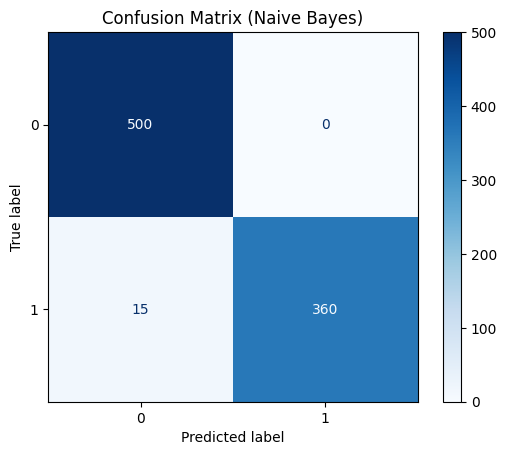

In [210]:
# --- EVALUATE ---
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_nb = nb_pipeline.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_nb, digits=4))

cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Naive Bayes)")
plt.show()

In [211]:
# --- SAVE MODEL ---
import joblib
joblib.dump(nb_pipeline, "spam_detector_nb_model.pkl")
print("✅ Naive Bayes model saved as 'spam_detector_nb_model.pkl'")

# --- ANALYZE FALSE NEGATIVES (Missed Spam) ---
false_negatives_idx = np.where((y_test.values == 1) & (y_pred_nb == 0))[0]
filename = "false_negatives.txt"
with open(filename, "w", encoding="utf-8") as f:
    f.write(f"Total false negatives (missed spam): {len(false_negatives_idx)}\n\n")
    for idx in false_negatives_idx:
        orig_idx = X_test.index[idx]
        f.write(f"--- Email index in test set: {idx} ---\n")
        f.write(f"Email Subject: {df.iloc[orig_idx]['subject']}\n")
        f.write(f"Email Text: {df.iloc[orig_idx]['combined_text']}\n")
        f.write(f"Actual Label: Spam\n")
        f.write(f"Predicted Label: Ham\n")
        f.write("-" * 50 + "\n")
print(f"✅ False negatives saved to: {filename}")

✅ Naive Bayes model saved as 'spam_detector_nb_model.pkl'
✅ False negatives saved to: false_negatives.txt


In [212]:
# --- TEST SAMPLE EMAILS ---
nb_pipeline = joblib.load("spam_detector_nb_model.pkl")
sample_emails = [
    {"subject": "Team Meeting Reminder", "body": "Dear team, this is a reminder for our meeting tomorrow at 10am in room 305."},
    {"subject": "Invoice Attached", "body": "Hi, please find attached the invoice for last month. Let me know if you have any questions."},
    {"subject": "Assignment Feedback", "body": "Your assignment has been marked. Please check the portal for your grade and feedback."},
    {"subject": "Lunch Plans?", "body": "Hey, are you free for lunch today at 1pm? Let me know!"},
    {"subject": "URGENT: Account Locked", "body": "Your account is locked. Verify your info here: http://phishingsite.com"},
    {"subject": "Your payment has been confirmed", "body": "Baseus Presenter Wireless Laser Pointer 2.4GHz Remote Controller for Mac 1 item from Shopee Delivered today Order number 250512NXGU9D17"},
    {"subject": "Your input Matters: Where did you find us?", "body": "Dear customer, Thank you for choosing Toyota! Your trust means the world to us. To help us serve you better, we’d love to get your feedback. Please take a moment to complete a short survey by clicking the link here. Your input will help us enhance our services and improve your overall experience. We promise it will only take a brief of your time. Thank you for your time and continued support! Best regards,   Toyota Customer Relations Team"},
]
print("\nTesting batch of sample emails with Naive Bayes...\n")
for i, email in enumerate(sample_emails, 1):
    combined_text = clean_text(email['subject'] + ' ' + email['body'])
    prediction = nb_pipeline.predict([combined_text])[0]
    print(f"Email {i}")
    print("Subject:", email['subject'])
    print("Prediction:", "Spam" if prediction == 1 else "Ham")
    print("-" * 40)


Testing batch of sample emails with Naive Bayes...

Email 1
Subject: Team Meeting Reminder
Prediction: Ham
----------------------------------------
Email 2
Subject: Invoice Attached
Prediction: Ham
----------------------------------------
Email 3
Subject: Assignment Feedback
Prediction: Ham
----------------------------------------
Email 4
Subject: Lunch Plans?
Prediction: Ham
----------------------------------------
Email 5
Subject: URGENT: Account Locked
Prediction: Spam
----------------------------------------
Email 6
Subject: Your payment has been confirmed
Prediction: Ham
----------------------------------------
Email 7
Subject: Your input Matters: Where did you find us?
Prediction: Spam
----------------------------------------
